# Chose 4 different regression techniques

## Read data
Only `train` file relevant for training:
`data/student_performance/StudentPerformance.shuf.train.csv`

`test` file doesn't contain labels:
`data/student_performance/StudentPerformance.shuf.test.csv`

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
student = pd.read_csv('data/student_performance/StudentPerformance.shuf.train.csv')

### Check data
`info()` method shows if there are missing values
it shows that there aren't any missing values (non-null for every feature)

In [4]:
student.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198 entries, 0 to 197
Data columns (total 32 columns):
id            198 non-null int64
Grade         198 non-null int64
school        198 non-null object
sex           198 non-null object
age           198 non-null int64
address       198 non-null object
famsize       198 non-null object
Pstatus       198 non-null object
Medu          198 non-null int64
Fedu          198 non-null int64
Mjob          198 non-null object
Fjob          198 non-null object
reason        198 non-null object
guardian      198 non-null object
traveltime    198 non-null int64
studytime     198 non-null int64
failures      198 non-null int64
schoolsup     198 non-null object
famsup        198 non-null object
paid          198 non-null object
activities    198 non-null object
nursery       198 non-null object
higher        198 non-null object
internet      198 non-null object
romantic      198 non-null object
famrel        198 non-null int64
freetime      198 no

## Preprocessing (without scaling)
Preprocessing is needed because data contains some nominal features.
For the nominal features we implement the following encoding schema:
- oneHot - encoding: each possible value gets it's own collumn, where it is 1 if the original feature is the collumn, otherwise 0 


In [5]:
for key in student.keys():
    if student[key].dtype == 'object':
        uniques = student[key].unique()
        if len(uniques) == 2:
            student[key] = student[key].apply(lambda x: 1 if x == uniques[0] else 0)
        else:
            for unique in uniques:
                student[key + '_' + unique] = student[key].apply(lambda x: 1 if x == unique else 0)
            student.drop(key, axis=1, inplace=True)

In [6]:
student.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198 entries, 0 to 197
Data columns (total 45 columns):
id                   198 non-null int64
Grade                198 non-null int64
school               198 non-null int64
sex                  198 non-null int64
age                  198 non-null int64
address              198 non-null int64
famsize              198 non-null int64
Pstatus              198 non-null int64
Medu                 198 non-null int64
Fedu                 198 non-null int64
traveltime           198 non-null int64
studytime            198 non-null int64
failures             198 non-null int64
schoolsup            198 non-null int64
famsup               198 non-null int64
paid                 198 non-null int64
activities           198 non-null int64
nursery              198 non-null int64
higher               198 non-null int64
internet             198 non-null int64
romantic             198 non-null int64
famrel               198 non-null int64
freetime       

## Feature Pearson Correlation

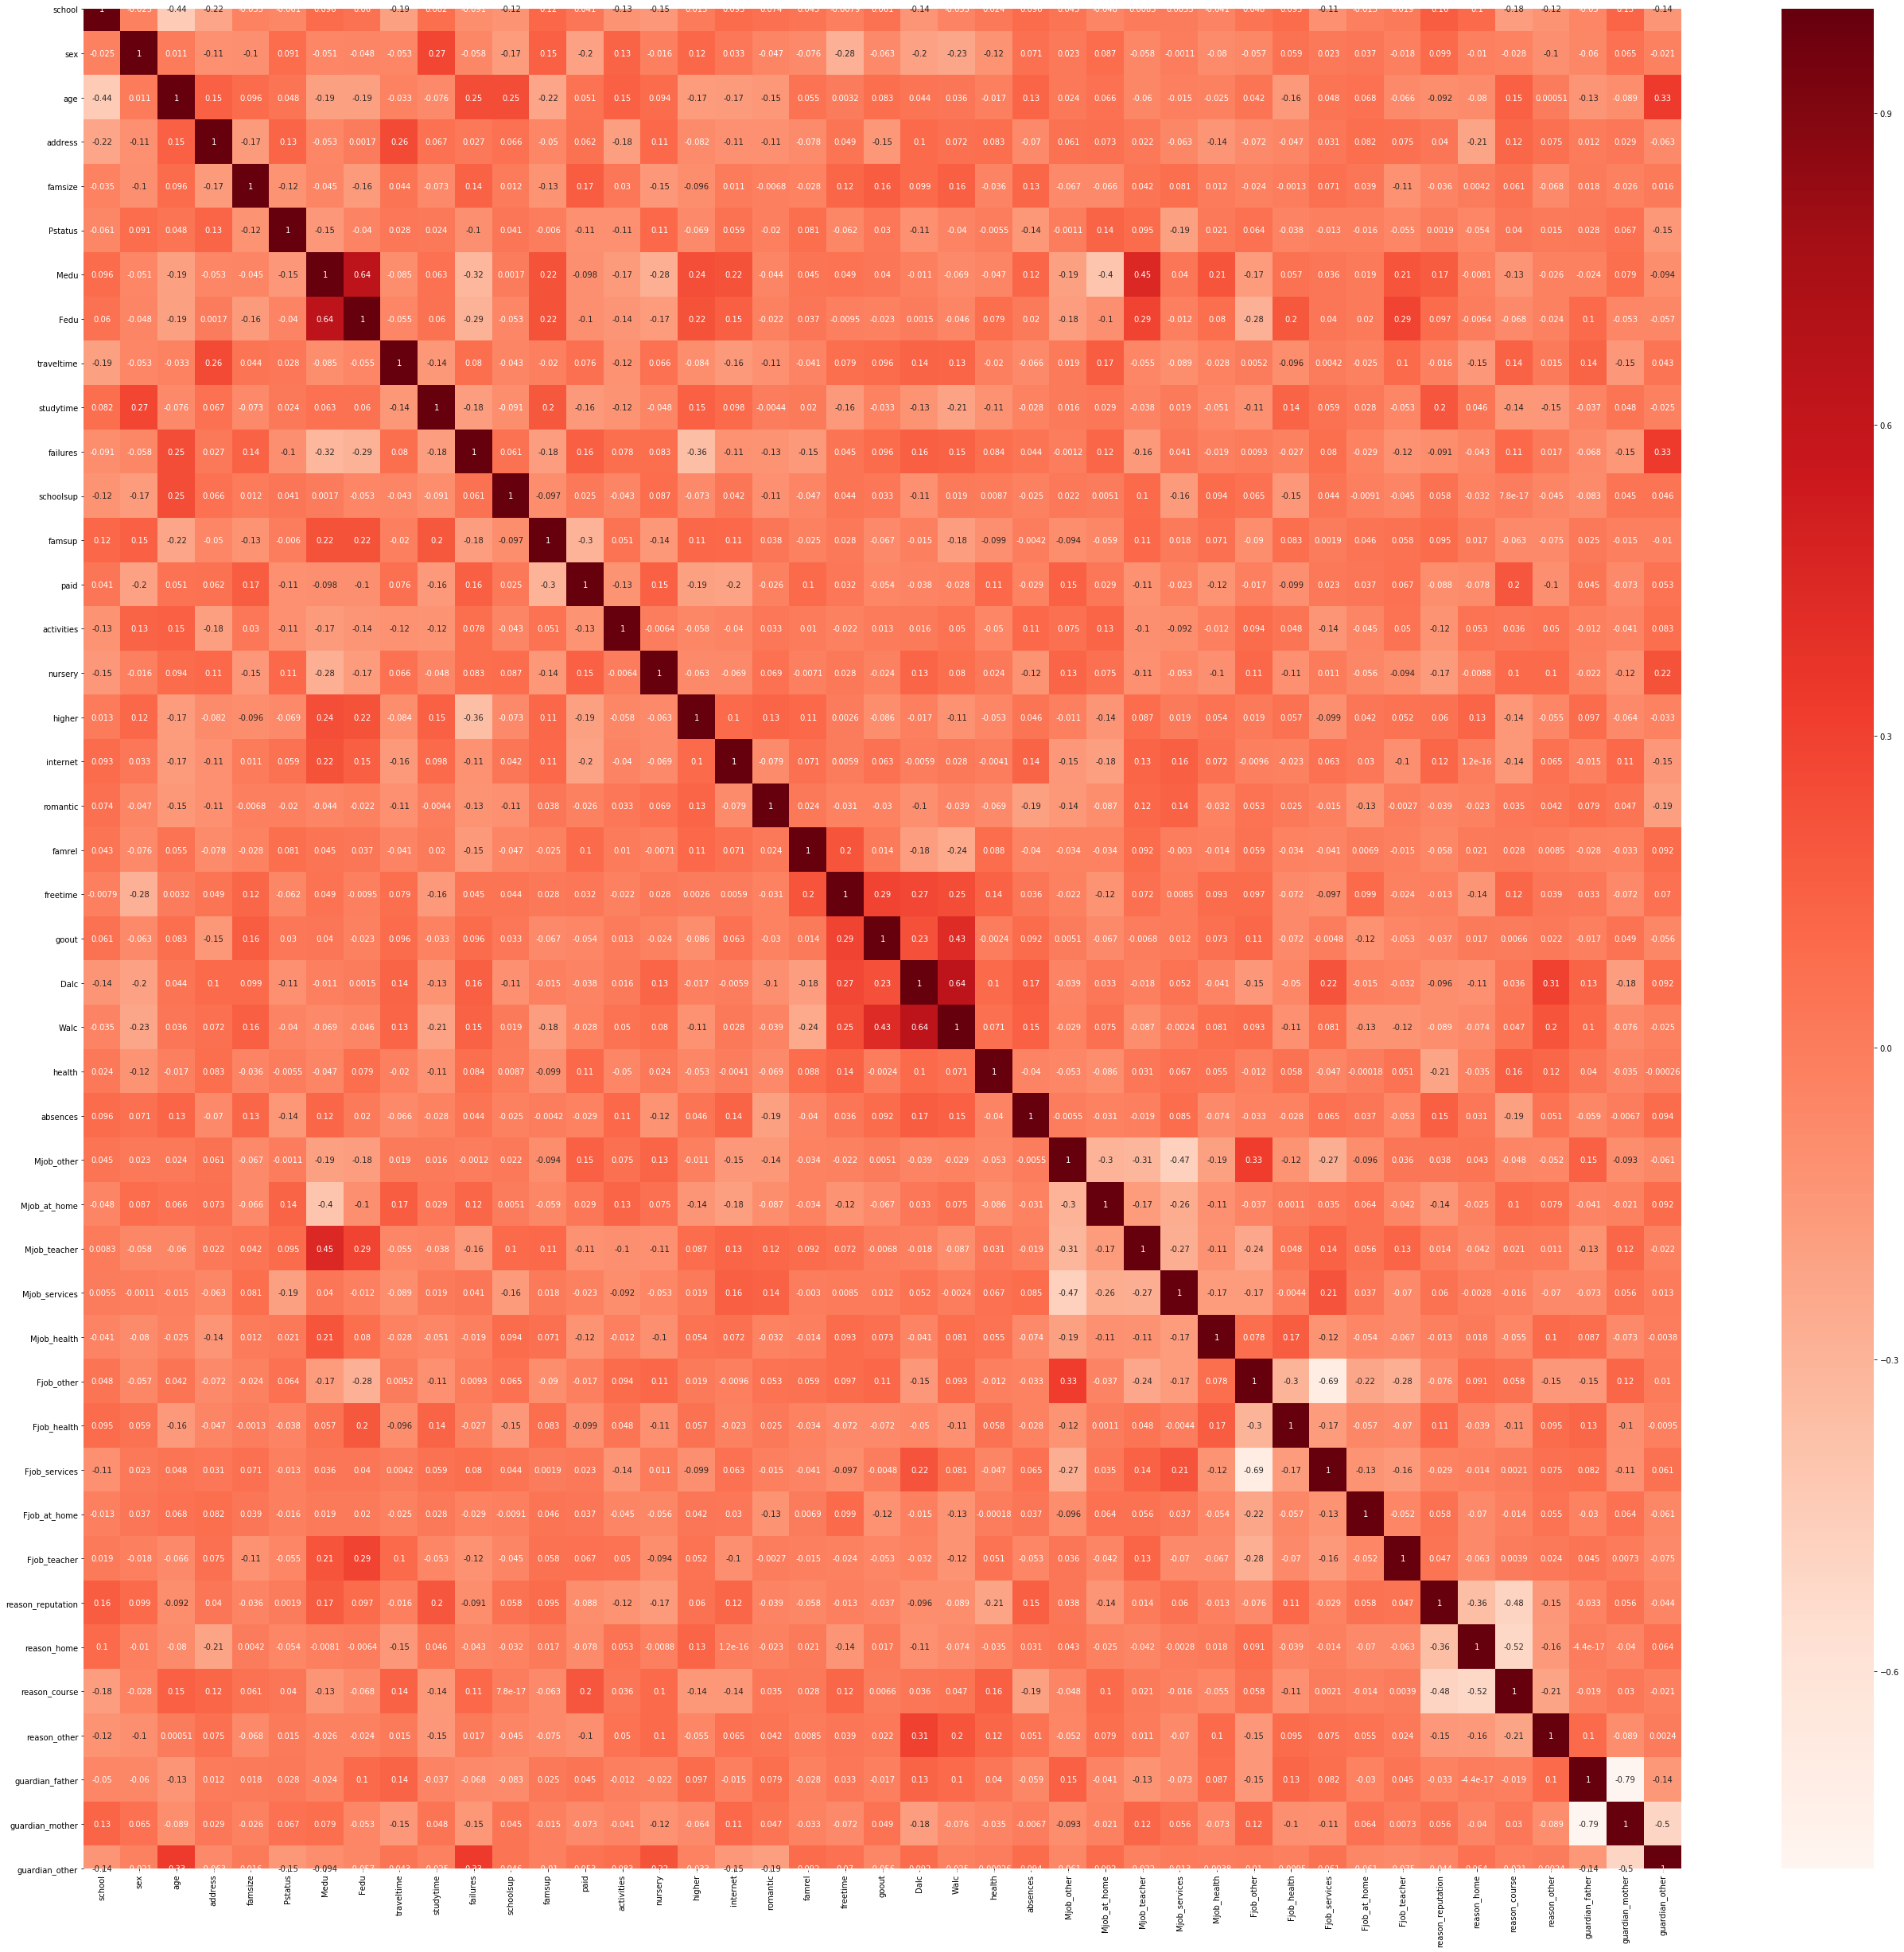

In [7]:
plt.figure(figsize=(45,43))
cor = student.drop(['id', 'Grade'],axis=1).corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.savefig('Correlation.png')
plt.show()

## Creating feature and target arrays

In [8]:
student_dropped = student.drop(['id'], axis = 1)
X = student_dropped.drop('Grade', axis = 1).values
y = student['Grade'].values

## Creating train and test data 


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

## Starting with a simple model to:
+ get a sense of how challenging the problem is
+ many more things might go wrong with complex models
+ how much signal can we pull out using basic models

## Ridge regression
__Score history:__
- Test set RMSE of rf: 4.728 (basic one hot encoding)
- Test set RMSE of rf: 4.715 (for binary features only one feature)

### Ridge parameters
- __alpha:__
    - regularization strenght: the higher the value, the stronger the regularization
- __fit_intercept:__
    - weather to calculate an intercept for this model (e. g. not needed if centered) 
- __normalize:__
    - if `fit_intercept` and `normalize` are both `True` the regressor X will be normalized

In [10]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

In [11]:
# create parameter list for ridge regression
params_ridge = {
    'alpha': [x/100. for x in range(0,151,10)],
    'normalize': [True, False],
    'fit_intercept': [True, False]
}

ridge = Ridge()

In [12]:
# setup cross validation parameter grid search
grid_ridge = GridSearchCV(estimator=ridge,
    param_grid=params_ridge,
    cv=3,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1)

In [13]:
# fitting model on training data
grid_ridge.fit(X_train, y_train)

Fitting 3 folds for each of 64 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:    2.2s finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='warn', n_jobs=-1,
             param_grid={'alpha': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8,
                                   0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5],
                         'fit_intercept': [True, False],
                         'normalize': [True, False]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=1)

In [14]:
# extracting best parameters (can be used for finer hyper parameter tuning)
grid_ridge.best_params_

{'alpha': 0.8, 'fit_intercept': True, 'normalize': True}

In [15]:
# predicting values and calculating the rmse-score
y_pred_ridge = grid_ridge.predict(X_test)
rmse_test_ridge = MSE(y_test, y_pred_ridge)**(1/2)
print('Test set RMSE of rf: {:.3f}'.format(rmse_test_ridge))

Test set RMSE of rf: 4.725


## Lasso regression
__Score history:__
- Test set RMSE of rf: 4.85 (for binary features only one feature)

### Lasso Parameters:
- __alpha:__
    - constant that multiplies the L1-Norm
- __fit_intercept:__
    - weather to calculate an intercept for this model (e. g. not needed if centered) 
- __normalize:__
    - if `fit_intercept` and `normalize` are both `True` the regressor X will be normalized
- __positive:__
    - when `True` forces the coefficients to be positive

In [22]:
from sklearn.linear_model import Lasso

In [23]:
params_lasso = {
    'alpha': [0.001, 0.005, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.1, 1.2],
    'normalize': [True, False],
    'fit_intercept': [True, False],
    'positive': [True, False] 
}

lasso = Lasso()

In [24]:
grid_lasso = GridSearchCV(estimator=lasso,
    param_grid=params_lasso,
    cv=3,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1)

In [19]:
grid_lasso.fit(X_train, y_train)

Fitting 3 folds for each of 112 candidates, totalling 336 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 415.1599278276003, tolerance: 1.1738
  positive)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 271.0276401671858, tolerance: 1.1184
  positive)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 425.14058480658946, tolerance: 1.195
  positive)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the nu

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'alpha': [0.001, 0.005, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6,
                                   0.7, 0.8, 0.9, 1, 1.1, 1.2],
                         'fit_intercept': [True, False],
                         'normalize': [True, False],
                         'positive': [True, False]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=1)

In [20]:
grid_lasso.best_params_

{'alpha': 0.1, 'fit_intercept': True, 'normalize': False, 'positive': False}

In [21]:
y_pred_lasso = grid_lasso.predict(X_test)
rmse_test_lasso = MSE(y_test, y_pred_lasso)**(1/2)
print('Test set RMSE of rf: {:.2f}'.format(rmse_test_lasso))

Test set RMSE of rf: 4.85


## Random Forest
__Score history:__
- Test set RMSE of rf: 4.668 (for binary features only one feature)

### Random Forest parameters
- __n_estimators:__
    - number of trees in the forest
- __max_depth:__
    - maximum depth of the tree
- __min_samples_split:__
    - the min. number of samples required to split an internal node
- __min_samples_leaf:__
    - the minimum number of samples required to be at a leaf node
- __min_weight_fraction_leaf:__
    - the minimum weighted fraction of the sum total of weights
- __max_features:__
    - the number of features to consider when looking for the best split
- __min_impurity_decrease:__
    - A node will be split if this split induces a decrease of the impurity greater than or equal to this value.

In [25]:
from sklearn.ensemble import RandomForestRegressor

In [26]:
rf = RandomForestRegressor(random_state=42)

In [27]:
# take a look at the rf's parameters
print(rf.get_params())

{'bootstrap': True, 'criterion': 'mse', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 'warn', 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


In [28]:
params_rf = {
    'n_estimators': [100],
    'max_depth': [None, 20, 21, 22],
    'min_samples_split': [2, 3, 4]
}

grid_rf = GridSearchCV(estimator=rf,
    param_grid=params_rf,
    cv=3,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1)

In [29]:
grid_rf.fit(X_train, y_train)


Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:   13.2s finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=42,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'max_depth': [None, 20, 21, 22],
  

In [30]:
grid_rf.best_params_

{'max_depth': None, 'min_samples_split': 4, 'n_estimators': 100}

In [32]:
y_pred = grid_rf.predict(X_test)
rmse_test = MSE(y_test, y_pred)**(1/2)
print('Test set RMSE of rf: {:.3f}'.format(rmse_test))


Test set RMSE of rf: 4.668


## Creating SVM
__Score history:__
- Test set RMSE of rf: 4.95 (for binary features only one feature)


### SVM parameters
- __c:__
    - penalty parameeter (higher => overfitting)
- __shrinking:__
    - weather to use the shrinking heuristic
- __kernel:__
    - specifies the kernel type

In [54]:
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler

In [55]:
scaler = RobustScaler()
svr = SVR()

In [56]:
svr.get_params()

{'C': 1.0,
 'cache_size': 200,
 'coef0': 0.0,
 'degree': 3,
 'epsilon': 0.1,
 'gamma': 'auto_deprecated',
 'kernel': 'rbf',
 'max_iter': -1,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [57]:
pipe = make_pipeline(scaler, svr)

In [58]:
params_svr = {'svr__C': [1.0, 1.1, 1.2, 1.3, 1.4],
 'svr__kernel': ['rbf', 'linear', 'poly', 'rbf', 'sigmoid'],
 'svr__shrinking': [True, False]}

grid_svr = GridSearchCV(estimator=pipe,
    param_grid=params_svr,
    cv=3,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1)

In [59]:
grid_svr.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/loca

/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default 

/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default 

/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default 

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('robustscaler',
                                        RobustScaler(copy=True,
                                                     quantile_range=(25.0,
                                                                     75.0),
                                                     with_centering=True,
                                                     with_scaling=True)),
                                       ('svr',
                                        SVR(C=1.0, cache_size=200, coef0=0.0,
                                            degree=3, epsilon=0.1,
                                            gamma='auto_deprecated',
                                            kernel='rbf', max_iter=-1,
                                            shrinking=True, tol=0.001,
                                            verbose=False))],
                   

In [60]:
y_pred_svr = grid_svr.predict(X_test)
rmse_test_svr = MSE(y_test, y_pred_svr)**(1/2)
print('Test set RMSE of rf: {:.2f}'.format(rmse_test_svr))


Test set RMSE of rf: 4.95


## Creating a GradientBoostingRegressor
__Score history:__
- Test set RMSE of rf: 4.71 (for binary features only one feature)

In [40]:
from sklearn.ensemble import GradientBoostingRegressor

In [41]:
gbt = GradientBoostingRegressor(random_state=42)


In [42]:
params_gbt = {
'n_estimators': [200, 300, 400],
'max_depth': [1, 2, 3, 4, 5, 6, 7],
'max_features': ['log2'],
'learning_rate': [0.05, 0.1, 0.15],
'subsample': [0.8]
    
}
# Instantiate 'grid_rf'
grid_gbt = GridSearchCV(estimator=gbt,
param_grid=params_gbt,
cv=3,
scoring='neg_mean_squared_error',
verbose=1,
n_jobs=-1)

In [43]:
grid_gbt.fit(X_train, y_train)

Fitting 3 folds for each of 63 candidates, totalling 189 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 189 out of 189 | elapsed:   35.9s finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=GradientBoostingRegressor(alpha=0.9,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100,
                                                 n_iter...
                             

In [44]:
grid_gbt.best_params_


{'learning_rate': 0.1,
 'max_depth': 7,
 'max_features': 'log2',
 'n_estimators': 300,
 'subsample': 0.8}

In [45]:
best_model = grid_gbt.best_estimator_
y_pred = best_model.predict(X_test)
rmse_test = MSE(y_test, y_pred)**(1/2)
print('Test set RMSE of rf: {:.2f}'.format(rmse_test))

Test set RMSE of rf: 4.71
